# This notebook has comparissons of the Wasserstein metric with the L2 metric

This notebook contains simulations of adding different noise values to the Normal and Uniform distributions, looking into cost matrices defined on L1(Linear Distance) and L2(Squared Distance).

In [1]:
import sys
import os

utils_path = os.path.abspath(r"C:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis")
if utils_path not in sys.path:
    sys.path.append(utils_path)
    
from utils.utils import *
from utils.Visualizations import *

import numpy as np
import pandas as pd
from ot.datasets import make_1D_gauss as gauss
import time
import tqdm
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets

In [2]:
res_values = [int(x) for x in np.linspace(start=100, stop=400, num=4)]
#res_values = [int(x) for x in np.linspace(start=100, stop=500, num=9)]
scale = 1
noise_values = np.logspace(start=-4, stop=1, num=31)
SNR_values = np.logspace(start=-2, stop=1, num=31)  # We want a multiplication of 3 + 1 because we start at 0

## Normal distribution

### Existing Data

In [8]:
df = pd.read_csv('csvs/results_measures_SNR_L2.csv')
res_values = df['Res'].unique()

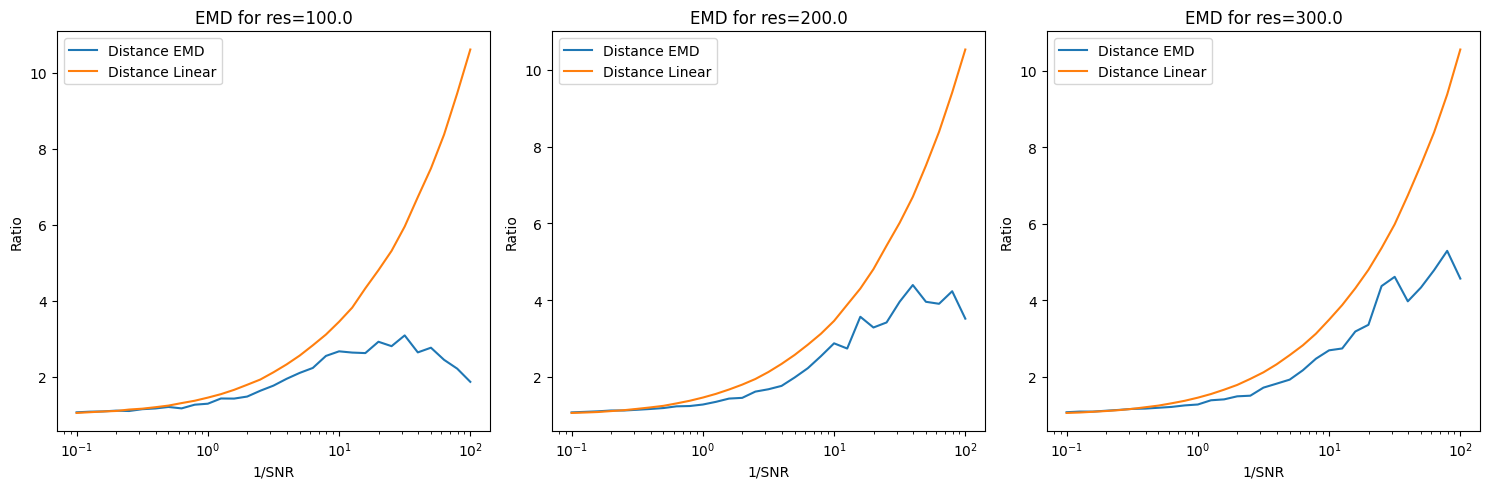

In [9]:
plt.figure(figsize=(15,5))

for i, res_option in enumerate(res_values[:3]):
    # Filter the dataframe based on current 'res' and 'scale' options
    filtered_df = df[(df['Res'] == res_option)]
    plt.subplot(1, 3, i + 1)
    plt.plot(1/filtered_df['SNR'], filtered_df['Ratios_EMD'], label='Distance EMD')
    plt.plot(1/filtered_df['SNR'], 1 / filtered_df['Ratios_Linear'], label='Distance Linear')
    plt.xscale('log')
    plt.title(f'EMD for res={res_option}')
    plt.xlabel('1/SNR')
    plt.ylabel('Ratio')
    plt.legend()

plt.tight_layout()
plt.show()

### Normal distribution - distance metric L1

In [3]:
first_center=0.35 
first_std=0.1
second_center=0.65
second_std=0.1

In [4]:
df4 = pd.DataFrame()

for res in tqdm.tqdm(res_values):
    for SNR in SNR_values:
        # Generate Gaussian distributions
        p = gauss(res, m=res * first_center, s=res * first_std)
        q = gauss(res, m=res * second_center, s=res * second_std)
        # Calculate signal power and determine noise level
        signal_power = (p ** 2).sum()
        noise_level = noise_from_SNR(SNR, signal_power=signal_power, res=res)
        
        df4 = run_experiment_and_append(df=df4, p=p, q=q, res=res, SNR=SNR, 
                                       scale_param=scale, num_samples=200, distance_metric='L1')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:17<00:00, 34.33s/it]


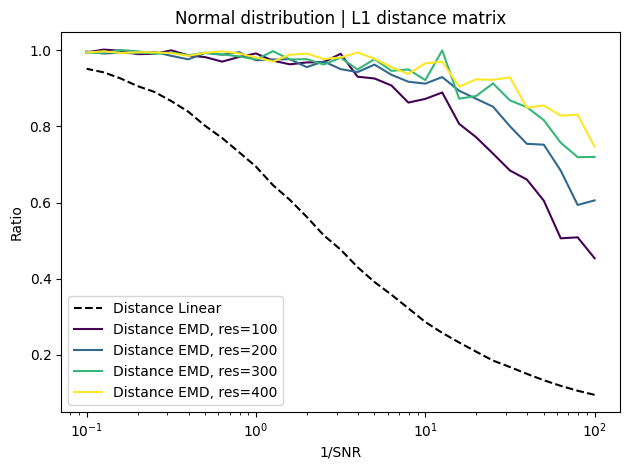

In [42]:
subset = df4[df4['Res'] == res_values[0]]
plt.plot(1/subset['SNR'], subset['Ratios_Linear'], label='Distance Linear', color='black', linestyle='--')

colors = plt.cm.viridis(np.linspace(0, 1, len(res_values)))  # Generate colors for each 'res' value

for i, res_option in enumerate(res_values):
    # Filter the dataframe based on current 'res' option
    filtered_df = df4[df4['Res'] == res_option]
    plt.plot(1/filtered_df['SNR'], filtered_df['Ratios_EMD'], label=f'Distance EMD, res={res_option}', color=colors[i])

plt.xscale('log')
plt.title('Normal distribution | L1 distance matrix')
plt.xlabel('1/SNR')
plt.ylabel('Ratio')
plt.legend()

plt.tight_layout()
plt.savefig('images/comparison/Normal_L1')

### Normal distribution - distance metric L2

In [8]:
df3 = pd.DataFrame()

for res in tqdm.tqdm(res_values):
    for SNR in SNR_values:
        # Generate Gaussian distributions
        p = gauss(res, m=res * first_center, s=res * first_std)
        q = gauss(res, m=res * second_center, s=res * second_std)
        # Calculate signal power and determine noise level
        signal_power = (p ** 2).sum()
        noise_level = noise_from_SNR(SNR, signal_power=signal_power, res=res)
        
        df3 = run_experiment_and_append(df=df3, p=p, q=q, res=res, SNR=SNR, 
                                       scale_param=scale, num_samples=200)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:06<00:00, 91.69s/it]


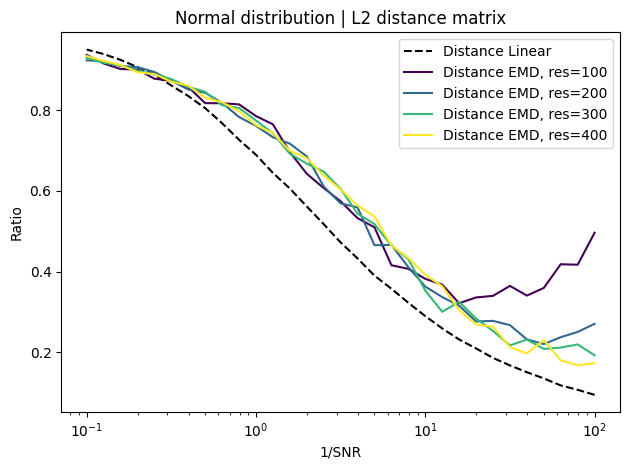

In [41]:
subset = df3[df3['Res'] == res_values[0]]
plt.plot(1/subset['SNR'], subset['Ratios_Linear'], label='Distance Linear', color='black', linestyle='--')

colors = plt.cm.viridis(np.linspace(0, 1, len(res_values)))  # Generate colors for each 'res' value

for i, res_option in enumerate(res_values):
    # Filter the dataframe based on current 'res' option
    filtered_df = df3[df3['Res'] == res_option]
    plt.plot(1/filtered_df['SNR'], 1/filtered_df['Ratios_EMD'], label=f'Distance EMD, res={res_option}', color=colors[i])

plt.xscale('log')
plt.title('Normal distribution | L2 distance matrix')
plt.xlabel('1/SNR')
plt.ylabel('Ratio')
plt.legend()

plt.tight_layout()
plt.savefig('images/comparison/Normal_L2')

### Sanity check

In [30]:
df3_subset = df3[(df3['Res'] == res_option)]
df4_subset = df4[(df4['Res'] == res_option)]

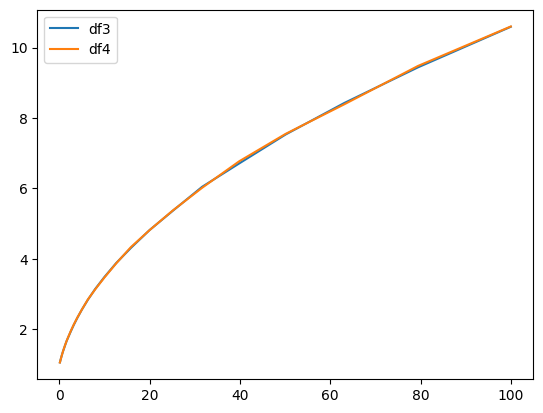

In [31]:
plt.plot(1/df3_subset['SNR'], 1 / df3_subset['Ratios_Linear'], label='df3')
plt.plot(1/df3_subset['SNR'], 1 / df4_subset['Ratios_Linear'], label='df4')

plt.legend()

## Uniform distribution:

### Single snippet of the loop for debugging

In [9]:
#add this as a test for one run going properly
distance_metric = 'L1'
X = np.linspace(0, 1, res)
noise=1e-3

# Define the y-values for the two distributions
p = np.where(x < 0.5, 2.0, 0)
p = p/p.sum()
q = np.where(x >= 0.5, 2.0, 0)
q = q/q.sum()

C = np.zeros([res, res], dtype=np.float64)
if distance_metric == 'L1':
    dist = lambda a, b: abs(a - b)
elif distance_metric == 'L2':
    dist = lambda a, b: (a - b) ** 2
for it1 in range(res):
    for it2 in range(res):
        C[it1, it2] = dist(X[it1], X[it2])

noise_p = np.random.normal(0, noise, res)
noise_q = np.random.normal(0, noise, res)

p_noised = p + noise_p
q_noised = q + noise_q

p_pos, p_neg = split_signed_measure(p_noised)
q_pos, q_neg = split_signed_measure(q_noised)

p_post = p_pos + q_neg
q_post = p_neg + q_pos

mean_distribs = (q_post.sum() + p_post.sum()) / 2
p_post = p_post * (mean_distribs / p_post.sum())
q_post = q_post * (mean_distribs / q_post.sum())

plan_classic, results_classic_add = calc_transport_pot_emd(p, q, C)
plan_noised, results_noised_add = calc_transport_pot_emd(p_post, q_post, C)

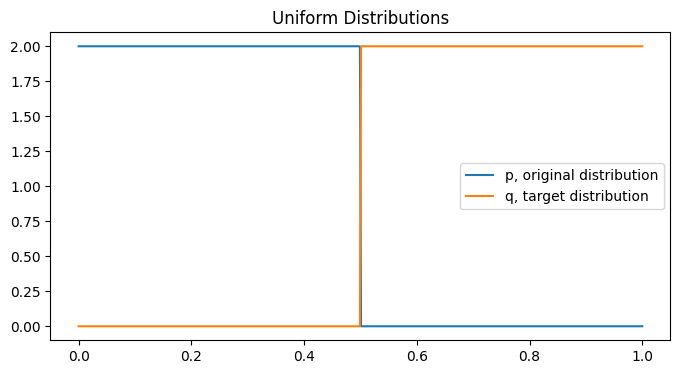

In [10]:
# Create an array of x-values from 0 to 1
x = np.linspace(0, 1, 500)

# Define the y-values for the two distributions
p = np.where(x < 0.5, 2, 0)
q = np.where(x >= 0.5, 2, 0)

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(x, p, label='p, original distribution')
plt.plot(x, q, label='q, target distribution')

plt.title('Uniform Distributions')
plt.legend()
plt.savefig('uniform.png')

### Uniform distribution - distance metric L1

In [13]:
df1 = pd.DataFrame()

for res in tqdm.tqdm(res_values):
    for SNR in SNR_values:
        x = np.linspace(0, 1, res)
        # Generate Uniform distributions
        p = np.where(x < 0.5, 2.0, 0)
        p = p/p.sum()
        q = np.where(x >= 0.5, 2.0, 0)
        q = q/q.sum()

        # Calculate signal power and determine noise level
        signal_power = (p ** 2).sum()
        noise_level = noise_from_SNR(SNR, signal_power=signal_power, res=res)
        
        df1 = run_experiment_and_append(df=df1, p=p, q=q, res=res, SNR=SNR, 
                                       scale_param=scale, num_samples=200, distance_metric='L1')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:51<00:00, 27.94s/it]


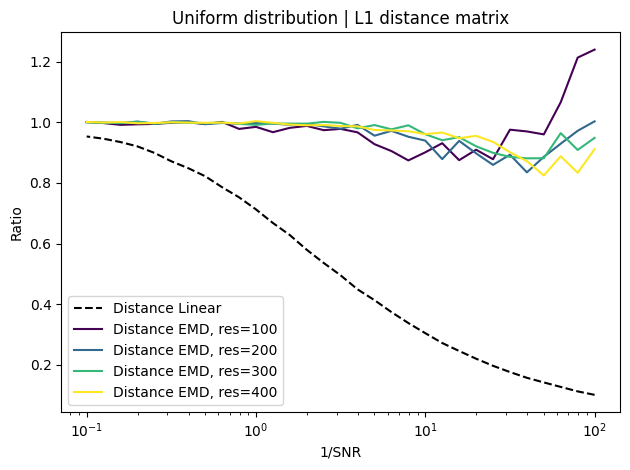

In [40]:
subset = df1[df1['Res'] == res_values[0]]
plt.plot(1/subset['SNR'], subset['Ratios_Linear'], label='Distance Linear', color='black', linestyle='--')

colors = plt.cm.viridis(np.linspace(0, 1, len(res_values)))  # Generate colors for each 'res' value

for i, res_option in enumerate(res_values):
    # Filter the dataframe based on current 'res' option
    filtered_df = df1[df1['Res'] == res_option]
    plt.plot(1/filtered_df['SNR'], 1/filtered_df['Ratios_EMD'], label=f'Distance EMD, res={res_option}', color=colors[i])

plt.xscale('log')
plt.title('Uniform distribution | L1 distance matrix')
plt.xlabel('1/SNR')
plt.ylabel('Ratio')
plt.legend()

plt.tight_layout()
plt.savefig('images/comparison/Uniform_L1')

### Uniform distribution - distance metric L2

In [16]:
df2 = pd.DataFrame()

for res in tqdm.tqdm(res_values):
    for SNR in SNR_values:
        x = np.linspace(0, 1, res)
        # Generate Uniform distributions
        p = np.where(x < 0.5, 2.0, 0)
        p = p/p.sum()
        q = np.where(x >= 0.5, 2.0, 0)
        q = q/q.sum()
        # Calculate signal power and determine noise level
        signal_power = (p ** 2).sum()
        noise_level = noise_from_SNR(SNR, signal_power=signal_power, res=res)
        
        df2 = run_experiment_and_append(df2, p=p, q=q, res=res, SNR=SNR, 
                                            scale_param=scale, num_samples=200)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:49<00:00, 42.42s/it]


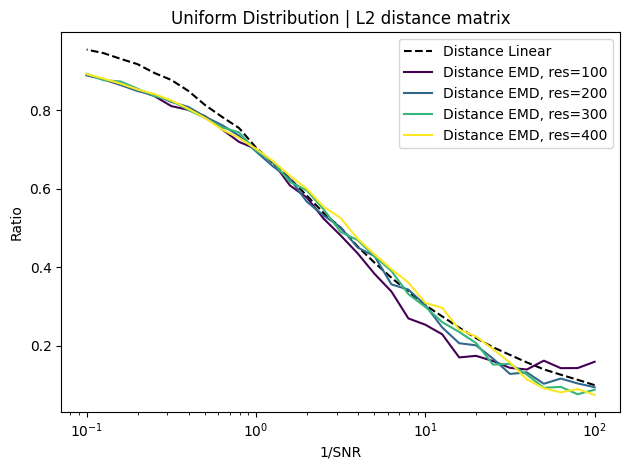

In [39]:
subset = df2[df2['Res'] == res_values[0]]
plt.plot(1/subset['SNR'], subset['Ratios_Linear'], label='Distance Linear', color='black', linestyle='--')

colors = plt.cm.viridis(np.linspace(0, 1, len(res_values)))  # Generate colors for each 'res' value

for i, res_option in enumerate(res_values):
    # Filter the dataframe based on current 'res' option
    filtered_df = df2[df2['Res'] == res_option]
    plt.plot(1/filtered_df['SNR'], 1/filtered_df['Ratios_EMD'], label=f'Distance EMD, res={res_option}', color=colors[i])

plt.xscale('log')
plt.title('Uniform Distribution | L2 distance matrix')
plt.xlabel('1/SNR')
plt.ylabel('Ratio')
plt.legend()

plt.tight_layout()
plt.savefig('images/comparison/Uniform_L2')

### Just a cool widget example

SelectionSlider(continuous_update=False, description='Resolution:', options=(100, 200, 300, 400), value=100)

ToggleButtons(description='Plot Type:', options=('EMD', 'Linear'), value='EMD')

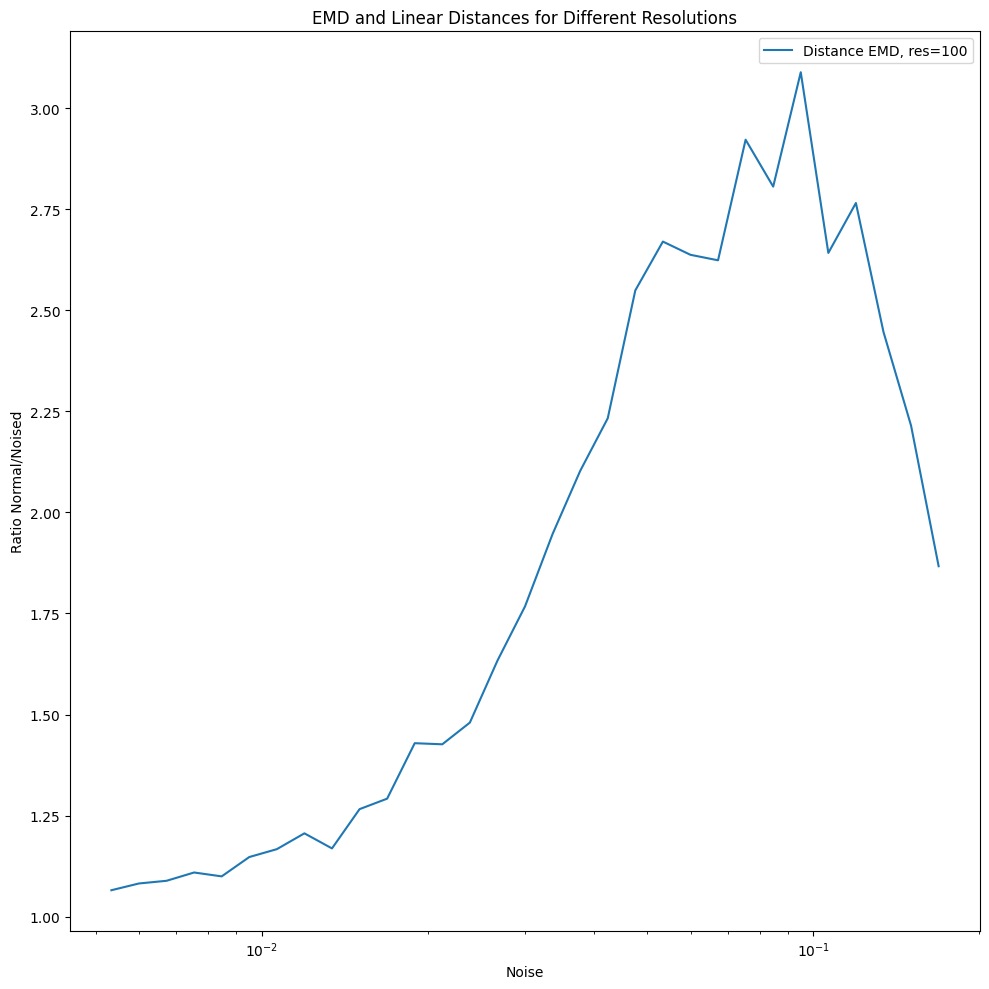

In [48]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Assuming df and res_values are defined somewhere in your code

def update_plot(resolution, plot_type):
    plt.figure(figsize=(10, 10))
    filtered_df = df[(df['Res'] == resolution) & (df['Noise_Param'] < 1)]

    if plot_type == 'EMD':
        plt.plot(filtered_df['Noise_Param'], filtered_df['Ratios_EMD'], label=f'Distance EMD, res={resolution}')
    else:
        plt.plot(filtered_df['Noise_Param'], 1 / filtered_df['Ratios_Linear'], label=f'Distance Linear, res={resolution}')

    plt.title('EMD and Linear Distances for Different Resolutions')
    plt.xlabel('Noise')
    plt.xscale('log')
    plt.ylabel('Ratio Normal/Noised')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Widgets
res_slider = widgets.SelectionSlider(options=res_values, description='Resolution:', continuous_update=False)
plot_type_toggle = widgets.ToggleButtons(options=['EMD', 'Linear'], description='Plot Type:')

# Display Widgets
display(res_slider, plot_type_toggle)

# Update Function
def on_value_change(change):
    update_plot(res_slider.value, plot_type_toggle.value)

# Observe changes in widgets
res_slider.observe(on_value_change, names='value')
plot_type_toggle.observe(on_value_change, names='value')

# Initial plot
update_plot(res_values[0], 'EMD')